In [55]:
import wfdb
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
import csv
from scipy import signal
from scipy.signal import butter, filtfilt, lfilter
from scipy.integrate import simps
import pywt
import random

import torch

14400   -0.220
14401   -0.215
14402   -0.225
14403   -0.210
14404   -0.210
         ...  
17995   -0.225
17996   -0.215
17997   -0.215
17998   -0.195
17999   -0.165
Name: MLII, Length: 3600, dtype: float64


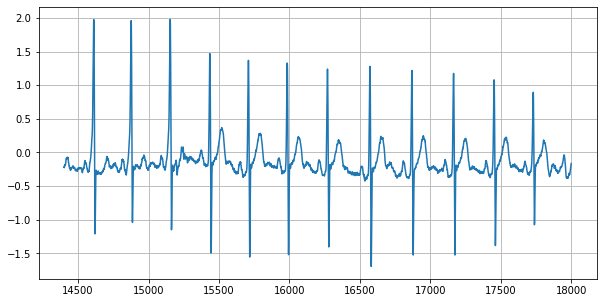

In [2]:
# visualize
filename = '../mitdb/230.csv'
example_file = pd.read_csv(filename, header=None)
example_file.columns = ['MLII', 'V5']

idx = 14400
MLII = example_file['MLII'][idx:idx+3600]
plt.rcParams['figure.figsize'] = (10, 5)
print(MLII)
plt.grid(True)
plt.plot(MLII)

14400    0.160
14401    0.180
14402    0.195
14403    0.200
14404    0.210
         ...  
17995   -0.105
17996   -0.100
17997   -0.115
17998   -0.095
17999   -0.070
Name: V5, Length: 3600, dtype: float64


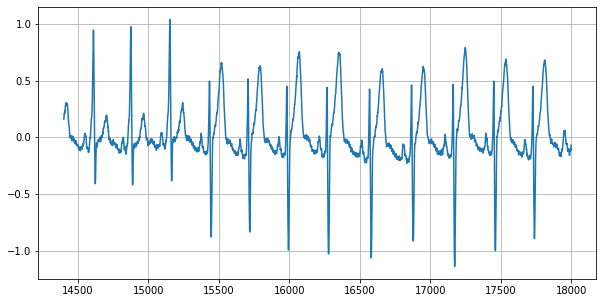

In [3]:
idx = 14400
MLII = example_file['V5'][idx:idx+3600]
plt.rcParams['figure.figsize'] = (10, 5)
print(MLII)
plt.grid(True)
plt.plot(MLII)

In [4]:
# cropping example
fc = 360
sec = 10
unit = fc * sec

record_name = '../mitdb/230'
with open(record_name + '.csv', 'r', newline="") as rd:
    reader = csv.reader(rd)
    
    data = np.array(list(reader))
    l2 = data[:, 0]
    
    start = 0
    end = unit    

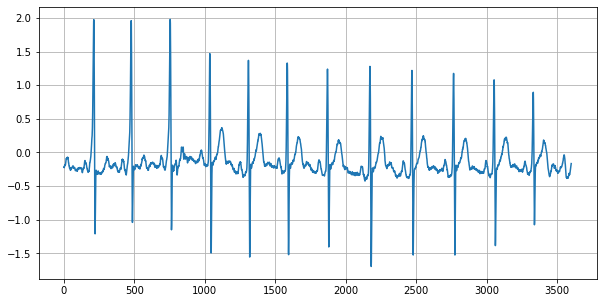

In [5]:
bb = np.array(l2[idx:idx+3600], dtype=float)
plt.rcParams['figure.figsize'] = (10, 5)
plt.grid(True)
idx = 14400
plt.plot(bb)

In [85]:
t = torch.Tensor(torch.linspace(0, 10, 360*10))

In [86]:
# Sample according the the y-axis
bb = torch.Tensor(bb)
y_axis = bb.unique()

# Random sampling
index = np.random.choice(y_axis.size(0), 200, replace=True)
y_axis = y_axis[index]  # sampled y_axis

# 각 200개에 대해서 동일한 애가 많은 경우에는 그 중에서도 sampling 하기
# now sample the time
t = t[np.in1d(bb.numpy(), y_axis.numpy())]
print(f'Sampled t length is {t.size(0)}')

Sampled t length is 1943


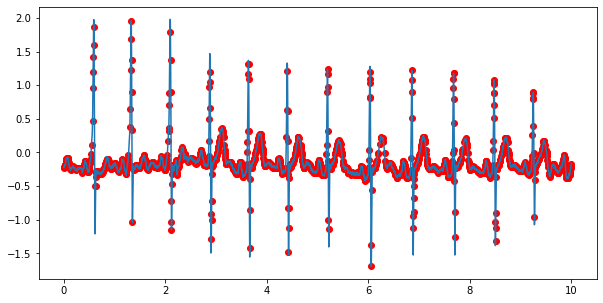

In [87]:
# Original Dataset
plt.rcParams['figure.figsize'] = (10, 5)
plt.plot(torch.Tensor(torch.linspace(0, 10, 360*10)).numpy(), bb)
plt.scatter(t.numpy(), bb[np.in1d(bb.numpy(), y_axis.numpy())].numpy(), color='red')
plt.show()


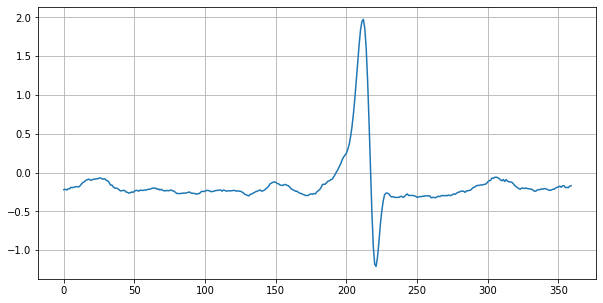

In [7]:
bb = np.array(l2[idx:idx+360], dtype=float)
plt.rcParams['figure.figsize'] = (10, 5)
plt.grid(True)
idx = 14400
plt.plot(bb)

In [37]:
######## Band Pass Filter ##########

def butter_lowpass_filter(data, lowcutoff, highcutoff, fs, order):
    lowcutoff = lowcutoff / nyq
    highcutoff = highcutoff / nyq
    # Get the filter coefficients
    # print(normal_cutoff)
    b, a = butter(order, [lowcutoff, highcutoff], btype='band', analog=False)
    w, h = signal.freqs(b, a)
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()
    y = filtfilt(b, a, data)
    #y = lfilter(b, a, data)
    return y

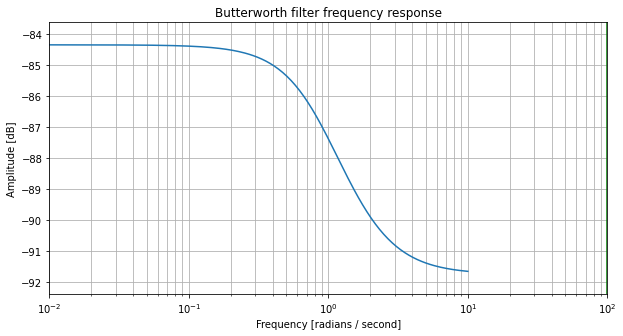

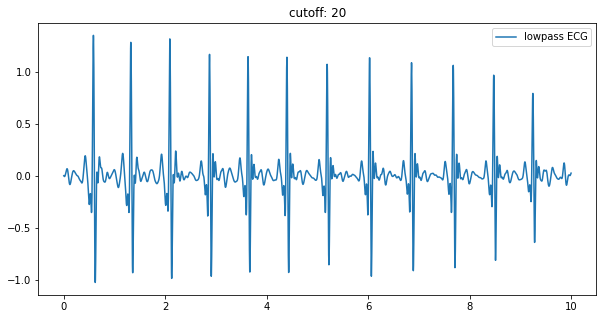

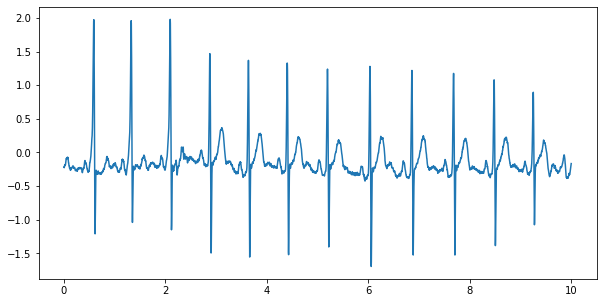

In [42]:
T = 10.0    # Sample Period
fs = 360   # Sample rate, Hz
t = np.linspace(0, T, int(T*fs))

nyq = 0.5 * fs   # Nyquist Frequency
order = 5        # how much smooth we want

n = int(T*fs)
lowcutoff = 5
highcutoff = 20

y = butter_lowpass_filter(bb, lowcutoff, highcutoff, fs, order)

plt.figure()
#plt.plot(t, bb, label ='original ECG')
#plt.plot(t, y, label ='lowpass ECG', linestyle='--')
plt.plot(t, y, label='lowpass ECG')
plt.legend()
plt.title('cutoff: {}'.format(cutoff))
#plt.title(f'order: {order}')
plt.show()

plt.plot(t, bb, label='original ECG')
plt.show()

In [29]:
######## Low Pass Filter ##########

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    # print(normal_cutoff)
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    w, h = signal.freqs(b, a)
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()
    y = filtfilt(b, a, data)
    #y = lfilter(b, a, data)
    return y

In [31]:
T = 10.0    # Sample Period
fs = 360   # Sample rate, Hz
t = np.linspace(0, T, int(T*fs))

nyq = 0.5 * fs   # Nyquist Frequency
order = 5        # how much smooth we want

n = int(T*fs)
cutoff = 20

y = butter_lowpass_filter(bb, cutoff, fs, order)

plt.figure()
#plt.plot(t, bb, label ='original ECG')
#plt.plot(t, y, label ='lowpass ECG', linestyle='--')
plt.plot(t, y, label='lowpass ECG')
plt.legend()
plt.title('cutoff: {}'.format(cutoff))
#plt.title(f'order: {order}')
plt.show()

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

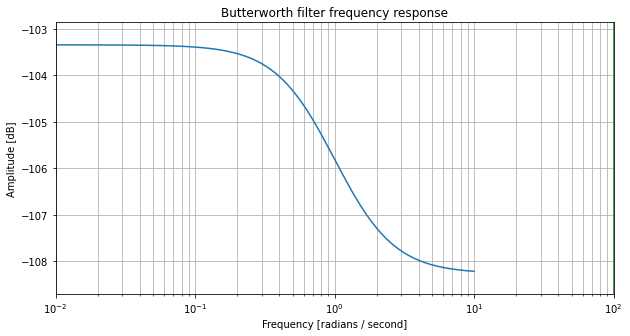

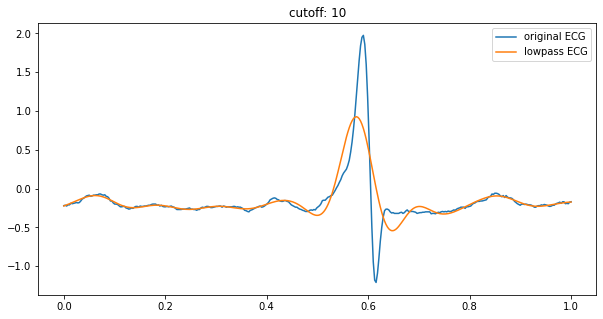

In [29]:
T = 1.0    # Sample Period
fs = 360   # Sample rate, Hz
t = np.linspace(0, T, int(T*fs))

nyq = 0.5 * fs   # Nyquist Frequency
order = 5        # how much smooth we want

n = int(T*fs)
cutoff = 10

y = butter_lowpass_filter(bb, cutoff, fs, order)

plt.figure()
plt.plot(t, bb, label ='original ECG')
#plt.plot(t, y, label ='lowpass ECG', linestyle='--')
plt.plot(t, y, label='lowpass ECG')
plt.legend()
plt.title('cutoff: {}'.format(cutoff))
#plt.title(f'order: {order}')
plt.show()


In [9]:
# FFT 적용
yfft = np.fft.fft(y)
yf = yfft/N
yf = yf[range(int(N/2))]

plt.plot(freq, abs(yf), 'b')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
#plt.xlim(0, 35)
plt.show()

NameError: name 'N' is not defined

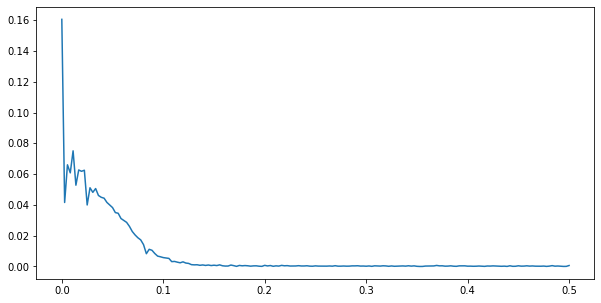

In [14]:
# Let's Fourier Transform
N = len(bb)     # length of signal
fs = 360   # Sample rate, Hz
dt = 1/fs   # sampling period

df = fs/N
f = np.arange(0, N) * dt
xf = np.fft.fft(bb) * dt

t = np.arange(0, N) * dt    # time = [0, dt, ..., (N-1)*dt]

k = np.arange(len(bb))
T = N / len(bb)
freq = k / T
freq = freq[range(int(N/2))]

yfft = np.fft.fft(bb)
yf = yfft / N
yf = yf[range(int(N/2))]

plt.plot(freq, abs(yf), 'b')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.axhline(y=0.0)
plt.xlim(0, 75)
plt.show()

In [108]:
N

360

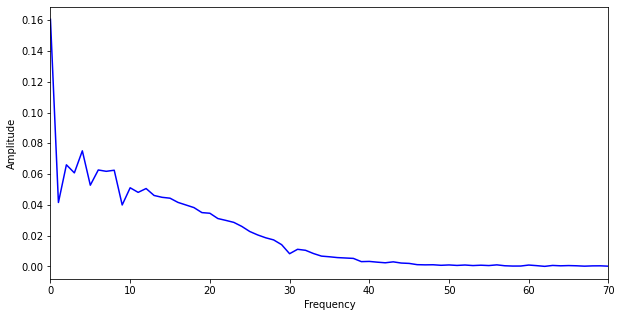

In [12]:
# Let's Fourier Transform
N = len(bb)
k = np.arange(len(bb))
T = N / len(bb)
freq = k / T
freq = freq[range(int(N/2))]

yfft = np.fft.fft(bb)
yf = yfft / N
yf = yf[range(int(N/2))]

plt.plot(freq, abs(yf), 'b')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim(0, 70)
plt.show()

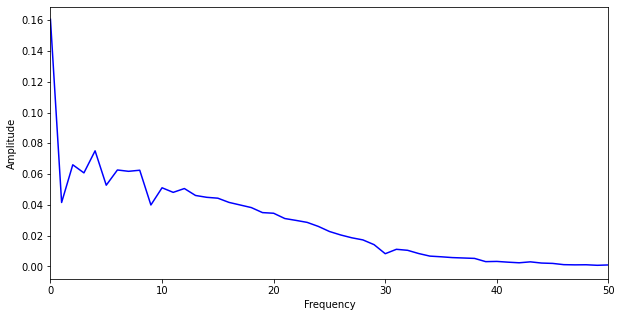

In [80]:
Fs = 360
Ts = 1/Fs
te = 1.0
t = np.arange(0.0, te, Ts)

# Signal is bb
z = bb
N = len(z)

k = np.arange(N)
T = N / Fs
freq = k / T
freq = freq[range(int(N/2))]

# FFT 적용
yfft = np.fft.fft(z)
yf = yfft/N
yf = yf[range(int(N/2))]

plt.plot(freq, abs(yf), 'b')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim(0, 50)
plt.show()

In [66]:
Fs = 2000
Ts = 1 / Fs
te = 1.0
t = np.arange(0.0, te, Ts)
N = len(t)
k = np.arange(N)
T = N / Fs
freq = k / T
freq = freq[range(int(N/2))]

In [69]:
N

2000

[1.76985764e-12 3.53971528e-11 3.36272952e-10 2.01763771e-09
 8.57496027e-09 2.74398729e-08 6.85996821e-08 1.37199364e-07
 2.22948967e-07 2.97265289e-07 3.26991818e-07 2.97265289e-07
 2.22948967e-07 1.37199364e-07 6.85996821e-08 2.74398729e-08
 8.57496027e-09 2.01763771e-09 3.36272952e-10 3.53971528e-11
 1.76985764e-12] [ 1.00000000e+00 -1.22160763e+01  7.19218136e+01 -2.71011603e+02
  7.32280329e+02 -1.50685693e+03  2.44834029e+03 -3.21431652e+03
  3.46099930e+03 -3.08493215e+03  2.28763103e+03 -1.41318629e+03
  7.25701875e+02 -3.07993423e+02  1.06941738e+02 -2.99029186e+01
  6.57387801e+00 -1.09479361e+00  1.29903127e-01 -9.78989753e-03
  3.52358351e-04]


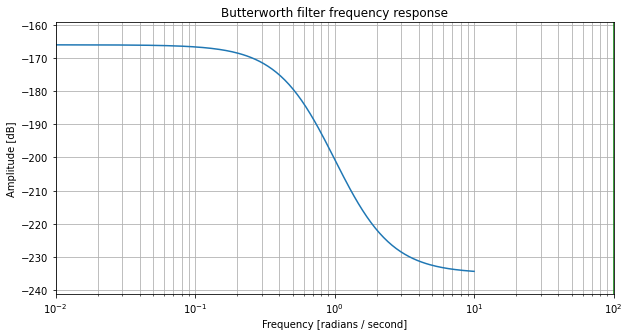

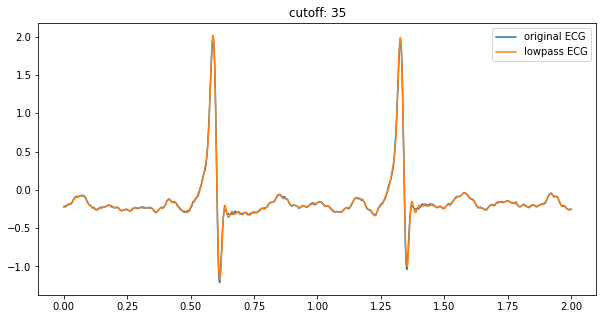

In [53]:
T = 2.0    # Sample Period
fs = 360   # Sample rate, Hz
t = np.linspace(0, T, int(T*fs))

nyq = 0.5 * fs   # Nyquist Frequency
order = 20        # how much smooth we want

n = int(T*fs)
cutoff = 35

y = butter_lowpass_filter(bb, cutoff, fs, order)

plt.figure()
plt.plot(t, bb, label ='original ECG')
#plt.plot(t, y, label ='lowpass ECG', linestyle='--')
plt.plot(t, y, label='lowpass ECG')
plt.legend()
plt.title('cutoff: {}'.format(cutoff))
plt.show()

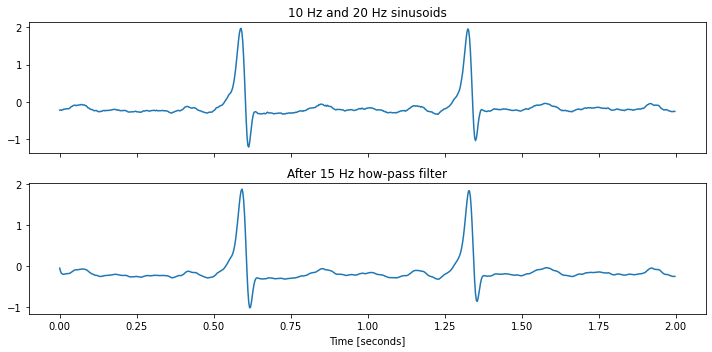

In [51]:
t = np.linspace(0, 2, len(bb), False)  # 2 seconds
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
sig = bb
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
#ax1.axis([0, 1, -2, 2])

sos = signal.butter(1, 100, 'lowpass', fs=1000, output='sos')
filtered = signal.sosfilt(sos, bb)
ax2.plot(t, filtered)
#ax2.plot(t, np.sin(2*np.pi*10*t))
ax2.set_title('After 15 Hz how-pass filter')
#ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

In [35]:
len(bb)

720

In [ ]:
### Toy Example ###
from scipy.signal import square,sawtooth

L = 1
freq = 2
width_range = 1
samples = 1000
terms = 50

# Generate sawtooth function
x = np.linspace(0, L, samples, endpoint=False)
y = sawtooth(2.0 * np.pi * x * freq/L, width = width_range)


In [155]:
# x = np.linspace(0, 1, len(bb))
# y = bb
# terms = 50
# #L = len(bb)
# L = 1



# Calculation of coefficients
a0 = 2./L*simps(y, x)
an = lambda n: 2.0 / L * simps(y * np.cos(2.*np.pi * n * x/L), x)
bn = lambda n: 2.0 / L * simps(y * np.sin(2.*np.pi * n * x/L), x)

# Sum of the series
s = a0/2. + sum([an(k)*np.cos(2. * np.pi * k * x/L) + bn(k)*np.sin(2.*np.pi*k*x/L) for k in range(1, terms+1)])

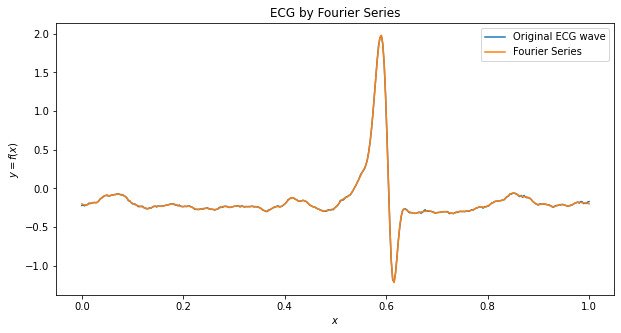

In [156]:
# Plotting
plt.plot(x, y, label = 'Original ECG wave')
plt.plot(x, s, label = 'Fourier Series')
plt.xlabel('$x$')
plt.ylabel('$y=f(x)$')
plt.legend(loc='best', prop={'size': 10})
plt.title('ECG by Fourier Series')
plt.show()

In [142]:
y

array([-0.22 , -0.215, -0.225, -0.21 , -0.21 , -0.19 , -0.195, -0.19 ,
       -0.185, -0.18 , -0.185, -0.18 , -0.16 , -0.135, -0.125, -0.11 ,
       -0.095, -0.09 , -0.085, -0.1  , -0.095, -0.085, -0.085, -0.08 ,
       -0.08 , -0.07 , -0.07 , -0.08 , -0.085, -0.08 , -0.1  , -0.105,
       -0.125, -0.16 , -0.16 , -0.185, -0.2  , -0.2  , -0.205, -0.22 ,
       -0.235, -0.235, -0.23 , -0.23 , -0.25 , -0.255, -0.265, -0.26 ,
       -0.25 , -0.255, -0.24 , -0.23 , -0.23 , -0.24 , -0.225, -0.23 ,
       -0.23 , -0.225, -0.225, -0.22 , -0.215, -0.215, -0.205, -0.2  ,
       -0.2  , -0.2  , -0.215, -0.21 , -0.225, -0.215, -0.23 , -0.235,
       -0.235, -0.23 , -0.235, -0.23 , -0.225, -0.235, -0.24 , -0.255,
       -0.27 , -0.27 , -0.27 , -0.27 , -0.265, -0.265, -0.265, -0.26 ,
       -0.255, -0.25 , -0.265, -0.265, -0.27 , -0.27 , -0.28 , -0.27 ,
       -0.27 , -0.25 , -0.24 , -0.245, -0.24 , -0.23 , -0.23 , -0.235,
       -0.245, -0.245, -0.24 , -0.235, -0.23 , -0.23 , -0.225, -0.225,
      

In [42]:
path = '../galerkin_pretest/dilation_test'
filname = 'finegrain_recon_ECG.pt'

In [10]:
import numpy as np
import torch
import torch.nn as nn
from torchdyn.models import DepthCat, NeuralDE


def FourierExpansion(n_range, s):
    s_n_range = s * n_range
    basis = [torch.cos(s_n_range), torch.sin(s_n_range)]
    return basis

class CoeffDecoder(nn.Module):
    def __init__(self, latent_dimension, coeffs_size):
        super().__init__()
        self.latent_dimension = latent_dimension
        self.fc1 = nn.Linear(latent_dimension, 2 * coeffs_size)
        self.act1 = nn.SiLU()
        self.fc2 = nn.Linear(2*coeffs_size, 2*coeffs_size)
        self.act2 = nn.SiLU()
        self.fc3 = nn.Linear(2*coeffs_size, coeffs_size)

    def forward(self, x):
        # input latent vector
        out = self.act1(self.fc1(x))
        out = self.act2(self.fc2(out))
        return self.fc3(out)

class WeightAdaptiveGallinear(nn.Module):
    def __init__(self, in_features, out_features, latent_dimension, expfunc, n_harmonics, n_eig, lower_bound, upper_bound):
        super().__init__()
        self.in_features, self.out_features, self.latent_dimension = in_features, out_features, latent_dimension
        self.expfunc = expfunc
        self.n_harmonics, self.n_eig = n_harmonics, n_eig
        self.lower_bound, self.upper_bound = lower_bound, upper_bound

        self.coeffs_size = in_features * out_features * n_harmonics * n_eig

        self.coeffs_generator = CoeffDecoder(latent_dimension, self.coeffs_size)

    def assign_weights(self, s, coeffs):
        #n_range = torch.linspace(self.lower_bound, self.upper_bound, self.n_harmonics).to(self.input.device)
        n_range = torch.Tensor(np.linspace(self.lower_bound, self.upper_bound, self.n_harmonics) * np.pi).to(self.input.device)
        basis = self.expfunc(n_range, s)
        B = []
        for i in range(self.n_eig):
            Bin = torch.eye(self.n_harmonics).to(self.input.device)
            Bin[range(self.n_harmonics), range(self.n_harmonics)] = basis[i]
            B.append(Bin)
        B = torch.cat(B, 1).permute(1, 0).to(self.input.device)
        X = torch.matmul(coeffs, B)
        return X.sum(1)

    def forward(self, x):
        assert x.size(1) == (self.in_features + self.latent_dimension + 1)
        self.batch_size = x.size(0)
        s = x[-1, self.in_features]
        self.input = torch.unsqueeze(x[:, :self.in_features], dim=-1)     # shape of (batch_size, in_features, 1)
        latent_variable = x[:, -self.latent_dimension:]   # shape of (batch_size, latent_dim)

        self.coeff = self.coeffs_generator(latent_variable)

        w = self.assign_weights(s, self.coeff)
        self.bias = w.unsqueeze(1)

        return self.bias

class AugmentedGalerkin(nn.Module):
    def __init__(self, in_features, out_features, latent_dim, expfunc, n_harmonics, n_eig, lower_bound, upper_bound):
        super().__init__()
        self.depth_cat = DepthCat(1)
        expfunc = FourierExpansion
        self.gallinear = WeightAdaptiveGallinear(in_features=in_features, out_features=out_features, latent_dimension=latent_dim, expfunc=expfunc, n_harmonics=n_harmonics,
                                                 n_eig=n_eig, lower_bound=lower_bound, upper_bound=upper_bound)
        self.z = torch.ones((1, 3), requires_grad=False).cuda()

    def forward(self, x):
        x = self.depth_cat(x)
        x = torch.cat((x, self.z), 1)
        out = self.gallinear(x)
        return out

class GalerkinDE_dilationtest(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.func = AugmentedGalerkin(in_features = args.in_features, out_features=args.out_features, latent_dim=args.latent_dimension,
                                      expfunc=args.expfunc, n_harmonics=args.n_harmonics, n_eig=args.n_eig, lower_bound=args.lower_bound, upper_bound=args.upper_bound)
        self.galerkin_ode = NeuralDE(self.func, solver='rk4')

    def forward(self, t, x):
        y0 = x[:, 0].unsqueeze(0)
        t = torch.squeeze(t[0])

        decoded_traj = self.galerkin_ode.trajectory(y0, t).transpose(0, 1)
        #mse_loss = nn.MSELoss()(decoded_traj, x)
        mse_loss = nn.MSELoss()(decoded_traj.squeeze(-1), x)
        return mse_loss

    def predict(self, t, x):
        y0 = x[:, 0].unsqueeze(0)
        t = torch.squeeze(t[0])

        decoded_traj = self.galerkin_ode.trajectory(y0, t).transpose(0, 1)
        return decoded_traj

/opt/conda/lib/python3.7/site-packages/wandb/vendor/watchdog/utils/bricks.py:175: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class OrderedSet(collections.MutableSet):


In [43]:
import easydict
# args
args = easydict.EasyDict({
    "in_features":1,
    "out_features":1,
    "latent_dimension":3,
    "expfunc":'fourier',
    "n_harmonics":10,
    "n_eig":2,
    "zero_out": False,
    "upper_bound": 10,
    "lower_bound": 1,
})

model = GalerkinDE_dilationtest(args)

In [44]:
import os
ckpt = torch.load(os.path.join(path, filname))
model.load_state_dict(ckpt['model_state_dict'])
print('Loaded!')

Loaded!


In [45]:
model.cuda()

GalerkinDE_dilationtest(
  (func): AugmentedGalerkin(
    (depth_cat): DepthCat()
    (gallinear): WeightAdaptiveGallinear(
      (coeffs_generator): CoeffDecoder(
        (fc1): Linear(in_features=3, out_features=40, bias=True)
        (act1): SiLU()
        (fc2): Linear(in_features=40, out_features=40, bias=True)
        (act2): SiLU()
        (fc3): Linear(in_features=40, out_features=20, bias=True)
      )
    )
  )
  (galerkin_ode): Neural DE:
  	- order: 1        
  	- solver: rk4
  	- integration interval: 0.0 to 1.0        
  	- num_checkpoints: 2        
  	- tolerances: relative 0.0001 absolute 0.0001        
  	- num_parameters: 2620        
  	- NFE: 0.0
          
  Integral loss: None
          
  DEFunc:
   DEFunc(
    (m): AugmentedGalerkin(
      (depth_cat): DepthCat()
      (gallinear): WeightAdaptiveGallinear(
        (coeffs_generator): CoeffDecoder(
          (fc1): Linear(in_features=3, out_features=40, bias=True)
          (act1): SiLU()
          (fc2): Linear

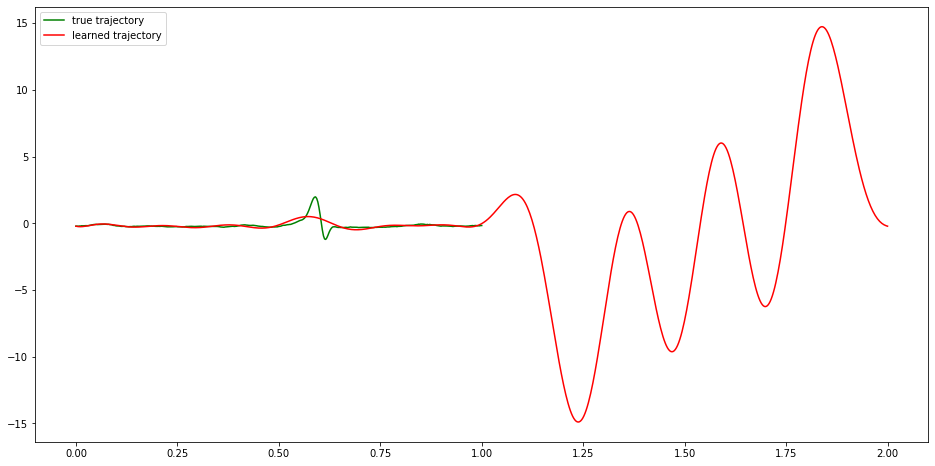

In [46]:
samp_sin = torch.Tensor(np.array(l2[idx:idx+360], dtype=float)).unsqueeze(0).cuda()
#test_ts = torch.Tensor(np.linspace(0., 25. * np.pi, 2700)).unsqueeze(0).to(samp_sin.device)
test_ts = torch.Tensor(np.linspace(0, 2, 720)).unsqueeze(0).to(samp_sin.device)
samp_ts = torch.Tensor(np.linspace(0, 1, 360)).unsqueeze(0).to(samp_sin.device).cuda()


#output = self.model.predict(test_ts, samp_sin, latent_v)
output = model.predict(test_ts, samp_sin)
test_tss = test_ts.squeeze()
#print(latent_v[0][0], latent_v[0][1])
#real_output = latent_v[0][2] * torch.sin(latent_v[0][0] * test_tss) + latent_v[0][3] * torch.cos(latent_v[0][1] * test_tss)
#real_output = torch.sin(latent_v[0][0] * test_tss) + torch.sin(latent_v[0][1] * test_tss) + torch.sin(latent_v[0][2] * test_tss) + torch.cos(latent_v[0][3] * test_tss) + torch.cos(latent_v[0][4] * test_tss) + torch.cos(latent_v[0][5] * test_tss)

# plot output
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
#ax.plot(test_ts.squeeze().cpu().numpy(), real_output.detach().cpu().numpy(), 'g', label='true trajectory')
ax.plot(samp_ts.squeeze().cpu().numpy(), samp_sin.squeeze().detach().cpu().numpy(), 'g', label='true trajectory')
ax.plot(test_ts.squeeze().cpu().numpy(), output.squeeze().detach().cpu().numpy(), 'r',
        label='learned trajectory')
#plt.plot(t, y, label='lowpass ECG')
plt.legend()
#plt.title('cutoff: {}'.format(cutoff))

#ax.axvline(samp_ts[-1])
#plt.title(latent_v)